In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
import timeit

In [3]:
os.getcwd()
os.chdir("/home/aumaron/Desktop/other_projects/")

In [4]:
previous_year = pd.read_excel("datasets/Online_Retail_II.xlsx", engine="openpyxl", sheet_name="Year 2009-2010")
current_year = pd.read_excel("datasets/Online_Retail_II.xlsx", engine="openpyxl", sheet_name="Year 2010-2011")

In [5]:
frames = [previous_year, current_year]
data = pd.concat(frames)
data.dropna(subset=["Customer ID", "Invoice", "InvoiceDate"], how="any", inplace=True)
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Total Price"] = data["Quantity"] * data["Price"]

data.to_csv("datasets/aggregated_online_retail.csv")

In [6]:
reference_date = data["InvoiceDate"].max()

rfm_matrix = data.groupby(["Customer ID"]).aggregate(
    {
        "InvoiceDate": lambda date: (reference_date - date.max()).days,
        "Invoice": "nunique",
        "Total Price": "sum"
    }
).reset_index()

rfm_matrix.rename(
    columns={
        "InvoiceDate": "Recency",
        "Invoice": "Frequency",
        "Total Price": "MonetaryValue"
    },
    inplace=True
)

rfm_matrix

,Customer ID,Recency,Frequency,MonetaryValue
0,12346.0,325,17,-64.68
1,12347.0,1,8,5633.32
2,12348.0,74,5,2019.40
3,12349.0,18,5,4404.54
4,12350.0,309,1,334.40
...,...,...,...,...
5937,18283.0,3,22,2736.65
5938,18284.0,429,2,436.68
5939,18285.0,660,1,427.00
5940,18286.0,476,3,1188.43


In [7]:
# Normalising the RFM matrix
numerical_columns = ["Recency", "Frequency", "MonetaryValue"]
for i in numerical_columns:
    scale = StandardScaler().fit(rfm_matrix[[i]])
    rfm_matrix[i] = scale.transform(rfm_matrix[[i]])

In [8]:
rfm_matrix

,Customer ID,Recency,Frequency,MonetaryValue
0,12346.0,0.581058,0.591554,-0.205148
1,12347.0,-0.948397,0.028030,0.202646
2,12348.0,-0.603798,-0.159812,-0.055995
3,12349.0,-0.868148,-0.159812,0.114705
4,12350.0,0.505529,-0.410267,-0.176587
...,...,...,...,...
5937,18283.0,-0.938956,0.904623,-0.004663
5938,18284.0,1.071994,-0.347653,-0.169267
5939,18285.0,2.162439,-0.410267,-0.169959
5940,18286.0,1.293860,-0.285039,-0.115465


## Hierarchical Clustering

In [ ]:
%%timeit
# Hierarchical clustering
# By default n_clusters = 4

cluster = AgglomerativeClustering(n_clusters=None,
                                  distance_threshold=0,
                                  compute_full_tree=True,
                                  compute_distances=True,
                                  affinity='euclidean',
                                  linkage='complete')
cluster.fit_predict(rfm_matrix.iloc[:, 1:len(rfm_matrix.columns)+1].to_numpy())
model = cluster.fit(rfm_matrix.iloc[:, 1:len(rfm_matrix.columns)+1].to_numpy())

In [ ]:
model

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, color_threshold = 2)
plt.xlabel("Number of clustered points in node (index of point if no brackets provided).")
plt.savefig('online_retail_dendrogram.pdf', format='pdf', bbox_inches='tight', facecolor="w", dpi=520)
# plt.show()

## KMeans (optimising n_clusters using Silhouette width)

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import timeit

In [9]:
# Iris dataset
from sklearn.datasets import load_iris

data = load_iris()
train_array = data["data"]
target = data["target"]

In [10]:
pd.Series(target).unique()

array([0, 1, 2])

Score for 2 clusters is -> 0.914791902158231
Score for 3 clusters is -> 0.5824713823150693
Score for 4 clusters is -> 0.5924940106340375
Score for 5 clusters is -> 0.6056122489985298
Score for 6 clusters is -> 0.5889279754569993
Score for 7 clusters is -> 0.5500260070925285
Score for 8 clusters is -> 0.5037236599546097
Score for 9 clusters is -> 0.5452610633719389
Score for 2 clusters is -> 0.914791902158231
Score for 3 clusters is -> 0.5824713823150693
Score for 4 clusters is -> 0.5924940106340375
Score for 5 clusters is -> 0.6056122489985298
Score for 6 clusters is -> 0.5889279754569993
Score for 7 clusters is -> 0.5500260070925285
Score for 8 clusters is -> 0.5037236599546097
Score for 9 clusters is -> 0.5452610633719389
Score for 2 clusters is -> 0.914791902158231
Score for 3 clusters is -> 0.5824713823150693
Score for 4 clusters is -> 0.5924940106340375
Score for 5 clusters is -> 0.6056122489985298
Score for 6 clusters is -> 0.5889279754569993
Score for 7 clusters is -> 0.55002600

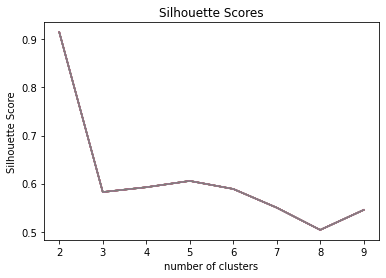

In [26]:
%%timeit -n 1
rfm_array = np.array(rfm_matrix.iloc[:, 1:])
score_list = []
for k in range(2,10):
    score_array = []
    # KMeans model
    km = KMeans(n_clusters=k, random_state=42)
    model = km.fit(rfm_array)
    cluster_labels = km.fit_predict(rfm_array)
    score = silhouette_score(rfm_array, km.labels_, metric='euclidean')
    score_array.append(score)
    sample_silhouette_values = silhouette_samples(rfm_array, cluster_labels)
    score_list.append((k, score))
    print(f"Score for {k} clusters is -> {score}")
    
plt.plot(list(range(2, 10)), [scores[1] for scores in score_list])
plt.xlabel('number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Scores");


In [ ]:
# rfm_array = np.array(train_array)
score_list = []
for k in range(2,10):
    score_array = []
    # KMeans model
    km = KMeans(n_clusters=k, random_state=42)
    model = km.fit(train_array)
    cluster_labels = km.fit_predict(train_array)
    score = silhouette_score(train_array, km.labels_, metric='euclidean')
    score_array.append(score)
    sample_silhouette_values = silhouette_samples(train_array, cluster_labels)
    score_list.append((k, score))
    print(f"Score for {k} clusters is -> {score}")
    
plt.plot(list(range(2, 10)), [scores[1] for scores in score_list])
plt.xlabel('number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Scores");

In [ ]:
def visualise_clusters(train_array):
    from sklearn.decomposition import PCA
    _dict = {}
    # Z-score the features
    scaler = StandardScaler()
    scaler.fit(train_array)
    X = scaler.transform(train_array)
    # The PCA model
    pca = PCA() # estimate only 2 PCs
    X_new = pca.fit_transform(X) # project the original data into the PCA space
    variance_ratios = pca.explained_variance_ratio_
    _dict["principal_components"] = X_new
    _dict["explained_variance"] = variance_ratios
    return _dict

_out = visualise_clusters(train_array)

In [ ]:
pc = _out["principal_components"]
exp = _out["explained_variance"]
print(exp)

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(train_array[:,0], train_array[:,1], c=target)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(pc[:,0], pc[:,1], c=target)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

## DBSCAN

In [9]:
from sklearn.cluster import DBSCAN

In [11]:
rfm_array = np.array(rfm_matrix.iloc[:, 1:])
clustering = DBSCAN(eps=1, min_samples=4).fit(rfm_array)
labels = clustering.labels_
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [12]:
list(set(labels))

[0, 1, -1]

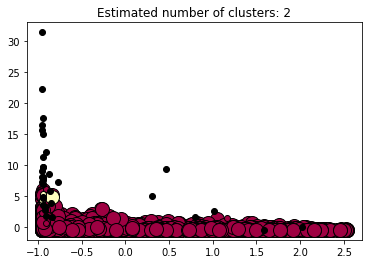

In [13]:
# Plot the result

import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = rfm_array[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = rfm_array[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# Create a subplot with 1 row and 2 columns
#     fig, (ax1) = plt.subplots(1)
#     fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(rfm_array) + (k + 1) * 100])
#     y_lower = 10
#     for i in range(k):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / k)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples
    
#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=score, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
#     ax2.scatter(rfm_array[:, 0], rfm_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = km.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % k),
#                  fontsize=14, fontweight='bold')
#     plt.savefig(f'online_retail_{k}_cluster_plots.pdf', format='pdf', bbox_inches='tight', facecolor="w", dpi=520)
    
# optimal_cluster_size = max(score_list, key = itemgetter(1))[0]